In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from matplotlib import animation, rc, rcParams
# from numba import jit, guvectorize, prange

rc('animation', html='jshtml')
rcParams['animation.embed_limit'] = 500

In [ ]:
#############

# Условие на временнУю дискретизацию:
#     характерный скачок молекул << характерное расстояние между молекулами

# Диффузия это случайные измения не координаты, а скорости?

# Для BCR есть вектор, отвечающий за их активацию

# Размер кластера BCR вычисляется более хитро чем размер рафта

# Заменить количества молекул на концентрации

#############

In [2]:
# Параметры модели

# Modeling area
SURFACE_AREA = 2

# Time
SIMULATION_TIME = 1
TIME_STEPS = 10

# BCR
BCR_NUMBER = 100
BCR_RADIUS = 0.005
BCR_RAFTS_RADIUS = 0.01
BCR_DIFFUSION_COEFFICIENT = 0.00001

# Lipid rafts
FREE_RAFTS_NUMBER = 40
FREE_RAFTS_RADIUS_MEAN = 0.02
RAFT_DIFFUSION_COEFFICIENT = 0.00008

##############

side_length = np.sqrt(SURFACE_AREA)
time_step = SIMULATION_TIME / TIME_STEPS

In [3]:
def scale_radii_to_points(radii, fig, ax):
    POINT_SIZE_COEF = 1.243 * 10**4
    fig_scale = fig.get_size_inches()[0]
    x_lim = ax.get_xlim()
    side_lenght = x_lim[1] - x_lim[0]
    return POINT_SIZE_COEF * (radii * fig_scale / side_lenght)**2

In [4]:
class MembraneDynamics:
    
    def __init__(self,
                 surface_area,
                 bcr_number,
                 bcr_radius,
                 bcr_rafts_radius,
                 bcr_diffusion_coef,
                 free_rafts_number,
                 free_rafts_radius_mean,
                 raft_diffusion_coef,
                ):
        
        # General
        self.side_length = np.sqrt(surface_area)
        self.time = 0
        
        # BCR
        self.bcr_relative_coordinates = np.zeros((bcr_number, 2))
        self.bcr_radii = np.ones((bcr_number, 1)) * bcr_radius
        self.bcr_raft_number = np.arange(bcr_number)
        self.bcr_is_activated = np.zeros(bcr_number, dtype=bool)
        self.bcr_diffusion_coef = bcr_diffusion_coef
        
        # Lipid rafts
        rafts_number = bcr_number + free_rafts_number
        self.lipid_rafts_coordinates = np.random.rand(rafts_number, 2) * self.side_length
        self.lipid_rafts_radii = np.empty((rafts_number, 1))
        self.lipid_rafts_radii[:bcr_number] = bcr_rafts_radius
        self.lipid_rafts_radii[bcr_number:] = np.random.chisquare(
            3, 
            size=(free_rafts_number, 1),
        ) * (free_rafts_radius_mean / 3)
        self.raft_diffusion_coef = raft_diffusion_coef
        
        self.evolve_system(0)
    
    
    def evolve_system(self, dt):
        self.time += dt
        sqrt_dt = sqrt(dt)
        
        # Lipid rafts
        self.diffusion(
            self.lipid_rafts_coordinates,
            self.lipid_rafts_radii,
            self.raft_diffusion_coef,
            sqrt_dt,
        )
        self.border_conditions_toroidal(
            self.lipid_rafts_coordinates,
            self.side_length,
        )
        (   # fusion
            self.lipid_rafts_coordinates,
            self.lipid_rafts_radii,
        ) = self.fusion(
            self.lipid_rafts_coordinates,
            self.lipid_rafts_radii,
            internal_elements=(
                self.bcr_raft_number,
                self.bcr_relative_coordinates,
            )
        )
        
        # BCR
        self.diffusion(
            self.bcr_relative_coordinates,
            self.bcr_radii,
            self.bcr_diffusion_coef,
            sqrt_dt,
        )
        self.border_conditions_hard(
            self.bcr_relative_coordinates,
            self.bcr_radii,
            self.lipid_rafts_radii[self.bcr_raft_number],
        )
        (   # fusion
            self.bcr_relative_coordinates,
            self.bcr_radii,
            self.bcr_raft_number,
        ) = self.fusion(
            self.bcr_relative_coordinates,
            self.bcr_radii,
            disjoint_groups = self.bcr_raft_number,
        )
        # Активация
    
    
    def get_rafts(self):
        return (self.lipid_rafts_coordinates,
                self.lipid_rafts_radii)
    
    
    def get_bcrs(self):
        bcr_coordinates = self.bcr_relative_coordinates + \
                          self.lipid_rafts_coordinates[self.bcr_raft_number]
        return (bcr_coordinates,
                self.bcr_radii)
    
    
    def get_image(self, imsize=(10,10)):
        fig, ax = plt.subplots(1, figsize=imsize)
        ax.set_xlim(0, side_length)
        ax.set_ylim(0, side_length)
        
        # Lipid rafts
        ax.scatter(*self.lipid_rafts_coordinates.T,
           s=scale_radii_to_points(self.lipid_rafts_radii, fig, ax),
           c='sandybrown',
           alpha=0.5,
          )
            
        # BCR
        bcr_coordinates = self.bcr_relative_coordinates + \
                  self.lipid_rafts_coordinates[self.bcr_raft_number]
        ax.scatter(*bcr_coordinates.T,
           s=scale_radii_to_points(self.bcr_radii, fig, ax),
           c='darkblue',
           alpha=0.8,
          )
            
        plt.show() 
                
    
    @staticmethod
    def distance_matrix(points):
        x = points[:, 0:1]
        y = points[:, 1:2]
        return np.sqrt((x - x.T)**2 + (y - y.T)**2)
    
    
    @staticmethod
    def combined_params(coordinates, radii):
        radii_sq_sum = (radii**2).sum()
        new_center = (coordinates * radii**2).sum(axis=0) / radii_sq_sum
        return new_center, sqrt(radii_sq_sum)
    
    
    @staticmethod
    def diffusion(centers, radii, k, time_step_root):
        shift = np.random.normal(size=(centers.shape[0], 2)) * k * time_step_root    
        centers += shift / np.log(1 + radii) # это плохая нормировка, но я исправлю
        
       
    @staticmethod
    def border_conditions_toroidal(coordinates, side_length):
        coordinates %= side_length
    
    
    @staticmethod
    def border_conditions_hard(relative_coordinates, self_radii, spot_radii):
        deviation_norm = np.linalg.norm(relative_coordinates, axis=1)
        effective_radii = (spot_radii - self_radii).flatten()
        aberration = deviation_norm > effective_radii
        returning_coefficient = effective_radii[aberration] / deviation_norm[aberration]
        relative_coordinates[aberration] *= returning_coefficient[:, None]
    
    
    @staticmethod
    def fusion(centers, radii, internal_elements=None, disjoint_groups=None):
        
        def calculate_fusion_list(index, centers, radii):
            n_clusters = centers.shape[0]
            dist_matr = MembraneDynamics.distance_matrix(centers)
            overlap_mask = radii + radii.T

            fusion_list = []
            for i in range(n_clusters):
                for j in range(i+1, n_clusters):
                    if dist_matr[i,j] <= overlap_mask[i,j]:
                        fusion_list.append((index[i], index[j]))
                        
            return fusion_list
        
        
        n_clusters = centers.shape[0]
        if disjoint_groups is None: # Если попарно слиться могут любые объекты из списка
            fusion_list = calculate_fusion_list(
                np.arange(n_clusters),
                centers,
                radii,
            )
        else:                       # Если объекты разделены на непересекающиеся группы
            fusion_list = []
            groups, inverse_index, group_sizes = np.unique(
                disjoint_groups,
                return_inverse=True,
                return_counts=True,
            )
            index = np.arange(n_clusters)
            for i in np.arange(groups.size)[group_sizes > 1]:
                group_index = (inverse_index == i)
                fusion_list.extend(calculate_fusion_list(
                    index[group_index],
                    centers[group_index],
                    radii[group_index],
                ))            
        
        connectivity_comps = MembraneDynamics.connectivity_components(
            n_clusters,
            fusion_list
        )
        disappeared_lines = []
        for component in connectivity_comps:
            
            new_center, new_radius = MembraneDynamics.combined_params(
                centers[component],
                radii[component],
            )
            
            dominant_class = component[0]
            
            if internal_elements:
                inter_locations, inter_centers = internal_elements
                for i in component:
                    updated_items = (inter_locations == i)
                    inter_locations[updated_items] = dominant_class
                    inter_centers[updated_items] += centers[i] - new_center
            
            centers[dominant_class] = new_center
            radii[dominant_class] = new_radius
            for i in component[1:]:
                disappeared_lines.append(i)
                
        if internal_elements:
            for i in sorted(disappeared_lines, reverse=True):
                inter_locations[inter_locations > i] -= 1
    
        return (np.delete(arr, disappeared_lines, axis=0) for arr in (
            centers, 
            radii, 
            disjoint_groups
        ) if arr is not None)
                    
            
    @staticmethod
    def connectivity_components(n_elements, edges):

        # breadth-first search
        def bfs(i, vertex, adjacency_list, comps):
            if comps[vertex]:
                return False

            comps[vertex] = i
            for v in adjacency_list[vertex]:
                bfs(i, v, adjacency_list, comps)

            return True
        
        # creating adjacency list (dict) from edges
        adjacency_list = {}
        for a, b in edges:
            adjacency_list[a] = adjacency_list.get(a, []) + [b]
            adjacency_list[b] = adjacency_list.get(b, []) + [a]
        
        # searching for connectivity components
        elements = np.arange(n_elements)
        comps = np.zeros_like(elements)
        i = 1
        for vertex in adjacency_list.keys():
            if bfs(i, vertex, adjacency_list, comps):
                i += 1
        
        # extracting components
        connectivity_comps = []
        for k in range(1, i):
            connectivity_comps.append(elements[comps == k])

        return connectivity_comps

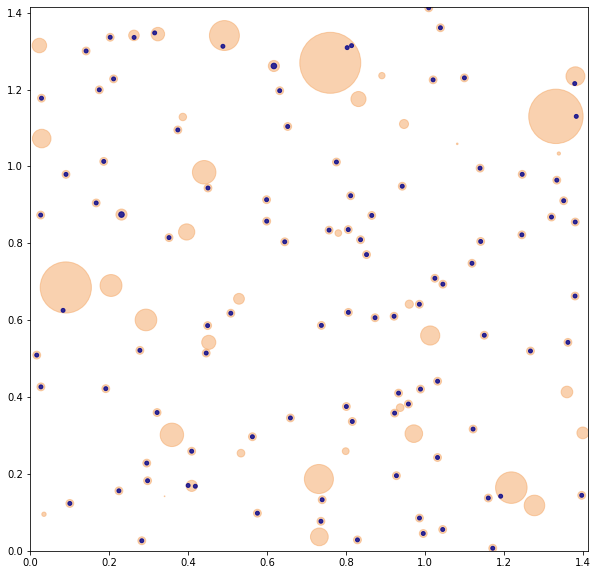

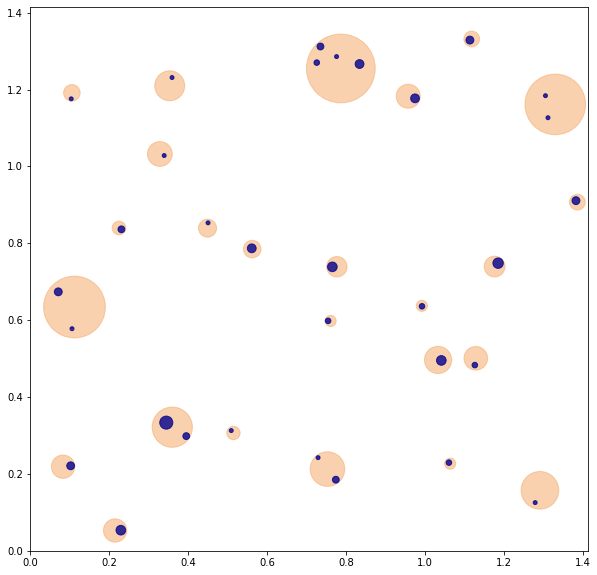

In [5]:
##################################################
#              Тест работы модели                #
#     Выполняется намного быстрее анимации,      #
# возвращает лишь начальное и конечное состояния #
##################################################

np.random.seed(0)

membrane_lr_dynamics = MembraneDynamics(
    
    # Modeling area
    surface_area=SURFACE_AREA,
    
    # BCR
    bcr_number=BCR_NUMBER,
    bcr_radius=BCR_RADIUS,
    bcr_rafts_radius=BCR_RAFTS_RADIUS,
    bcr_diffusion_coef=BCR_DIFFUSION_COEFFICIENT,
    
    # Lipid rafts
    free_rafts_number=FREE_RAFTS_NUMBER,
    free_rafts_radius_mean=FREE_RAFTS_RADIUS_MEAN,
    raft_diffusion_coef=RAFT_DIFFUSION_COEFFICIENT,
)

membrane_lr_dynamics.get_image()

for i in range(10000):    # TIME_STEPS
    membrane_lr_dynamics.evolve_system(time_step)
    
membrane_lr_dynamics.get_image()

In [ ]:
######################
# Настройка анимации #
######################

np.random.seed(0)

membrane_lr_dynamics = MembraneDynamics(
    
    # Modeling area
    surface_area=SURFACE_AREA,
    
    # BCR
    bcr_number=BCR_NUMBER,
    bcr_radius=BCR_RADIUS,
    bcr_rafts_radius=BCR_RAFTS_RADIUS,
    bcr_diffusion_coef=BCR_DIFFUSION_COEFFICIENT,
    
    # Lipid rafts
    free_rafts_number=FREE_RAFTS_NUMBER,
    free_rafts_radius_mean=FREE_RAFTS_RADIUS_MEAN,
    raft_diffusion_coef=RAFT_DIFFUSION_COEFFICIENT,
)

# set up figure and animation
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim(0, side_length)
ax.set_ylim(0, side_length)

time_text = ax.text(0.02, 0.97, '', transform=ax.transAxes)
lipid_rafts = ax.scatter([], [], c='sandybrown', alpha=0.5)
bcrs = ax.scatter([], [], c='darkblue', alpha=0.8)


def init():
    """initialize animation"""
    global lipid_rafts, bcrs, time_text
    return lipid_rafts, bcrs, time_text


def animate(i):
    """perform animation step"""
    global membrane_lr_dynamics, lipid_rafts, bcrs, time_text
    
    membrane_lr_dynamics.evolve_system(time_step)
    time_text.set_text(f'time = {membrane_lr_dynamics.time:.1f}')
    
    lipid_rafts_centers, lipid_rafts_radii = membrane_lr_dynamics.get_rafts()
    lipid_rafts.set_offsets(lipid_rafts_centers)
    lipid_rafts.set_sizes(scale_radii_to_points(lipid_rafts_radii, fig, ax).flatten())
    
    bcr_centers, bcr_radii = membrane_lr_dynamics.get_bcrs()
    bcrs.set_offsets(bcr_centers)
    bcrs.set_sizes(scale_radii_to_points(bcr_radii, fig, ax).flatten())
        
    return lipid_rafts, bcrs, time_text

ani = animation.FuncAnimation(fig, animate, frames=5000,
                              interval=30, blit=True, init_func=init)

plt.close()

In [ ]:
# Запустите эту ячейку для рендеринга созданной анимации

ani